In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords                # stopwords are removed from text to keep just useful info
from nltk import word_tokenize, sent_tokenize

import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['word2vec-nlp-tutorial', 'glove6b100dtxt', 'imdb-review-dataset']


In [2]:
raw_train_data_labeled = pd.read_csv("../input/word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
raw_train_data_unlabeled = pd.read_csv("../input/word2vec-nlp-tutorial/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
raw_test_data = pd.read_csv("../input/word2vec-nlp-tutorial/testData.tsv", header=0, delimiter="\t", quoting=3)

imdb_data = pd.read_csv('../input/imdb-review-dataset/imdb_master.csv',encoding="latin-1", index_col=0)
print(len(imdb_data))
imdb_data.head()

100000


,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
imdb_data = imdb_data.drop(["type","file"],axis=1)
imdb_data['sentiment'] = imdb_data['label'].map({"neg":0, "pos":1})
imdb_data = imdb_data.drop(["label"],axis=1)
imdb_data = imdb_data.dropna() # 删除缺失数据
imdb_data = imdb_data[['sentiment','review']]

imdb_data.head()

,sentiment,review
0,0.0,Once again Mr. Costner has dragged out a movie...
1,0.0,This is an example of why the majority of acti...
2,0.0,"First of all I hate those moronic rappers, who..."
3,0.0,Not even the Beatles could write songs everyon...
4,0.0,Brass pictures (movies is not a fitting word f...


In [4]:
X = raw_train_data_labeled['review']
y = raw_train_data_labeled['sentiment']

In [5]:
review_data = X.append(raw_test_data['review'])
review_data = review_data.append(imdb_data['review'])
review_data.shape

(100000,)

In [6]:
ntrain = X.shape[0]
df = raw_train_data_labeled.append(raw_test_data, sort=False)
df = df.drop(['sentiment'], axis=1)
df_review = df['review']

In [7]:
'''
Here we will do preprocessing
1. Removing punctuations
2. Lowering all words
3. removing non-alphabet things
4. removing stop words
5. Tokenizing the sentence
'''
import string

review_lines = list()
lines = review_data.values.tolist()

for line in lines:
    
    '''
    breaks line into it's sub parts like each word and comma etc,
    https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
    '''
    tokens = word_tokenize(line)   
    
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    review_lines.append(words)

In [8]:
'''
gensim is python library for training word embeddings in given data
for more information visit: 
1. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
2. http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XEoWKVwzbIV
'''
import gensim

embedding_vector_size = 150
# now training embeddings for each word 
model_1 = gensim.models.Word2Vec(sentences = review_lines, size=embedding_vector_size, min_count=1, window=5, workers=4 )

# to get total number of unique words
words = list(model_1.wv.vocab)

print("vocab size:", len(words))

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


vocab size: 135639


In [9]:
import string

review_lines_1 = list()
lines = X.values.tolist()

for line in lines:
    
    '''
    breaks line into it's sub parts like each word and comma etc,
    https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
    '''
    tokens = word_tokenize(line)   
    
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    review_lines_1.append(words)

Text(0, 0.5, 'frequency')

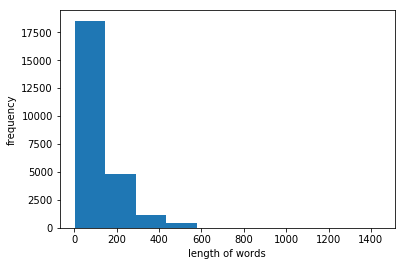

In [10]:
leng=0
length = [(leng + len(x)) for x in review_lines_1]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

In [11]:
import math
avg_length = sum(length)/len(review_lines_1)

# if words are more than max_length then they are skipped, if less than padding with 0 is done
print(avg_length)

123.5178


In [12]:
#max_len = math.ceil(avg_length)             # this is used to decide how man words in seq to keep
max_len = math.ceil(avg_length)
'''
Now we have trained the embeddings, we now have embedding vector for each word. We will
convert our text training data to numeric using theseword embeddings.
First, we need to make length of each input same, therefore we'll do padding. But padding happends 
on numeric data, therefore we'll convert texts to sequences using tokenize() function. Then add padding
Then we'll replace each non-zero numeric resulted from texts to sequences to its corresponding word
embedding.
'''
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines                   # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

In [13]:
# Preparing embedding matrix
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
np.save('../embedding_matrix_1.npy',embedding_matrix)
np.save('embedding_matrix_1.npy',embedding_matrix)

In [15]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines_1                   # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

In [16]:
X = train_test_data
# X = X.reshape(-1,124)
y1 = y
X.shape

(25000, 124)

In [17]:
y1.shape

(25000,)

ReduceLROnPlateau
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
当评价指标不在提升时，减少学习率

当学习停滞时，减少2倍或10倍的学习率常常能获得较好的效果。该回调函数检测指标的情况，如果在patience个epoch中看不到模型性能提升，则减少学习率

keras 中文文档
https://keras-cn.readthedocs.io/en/latest/other/callbacks/

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X , y1, test_size=0.2, random_state=42, shuffle=True)

In [19]:
# model = Sequential()

# model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
#                     input_length = max_len, weights = [embedding_matrix]))
# model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
# model.add(Dense(10))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
# print(model.summary())

In [20]:
# history = model.fit(X_train, y_train, epochs = 30, batch_size = 512, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])